In [1]:
import os
import glob
import cv2
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import defaultdict
import random

import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LinearLR, ReduceLROnPlateau
import torchvision.models as models
import torch.nn.functional as F

C:\Users\Petr\anaconda3\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Пункт 1

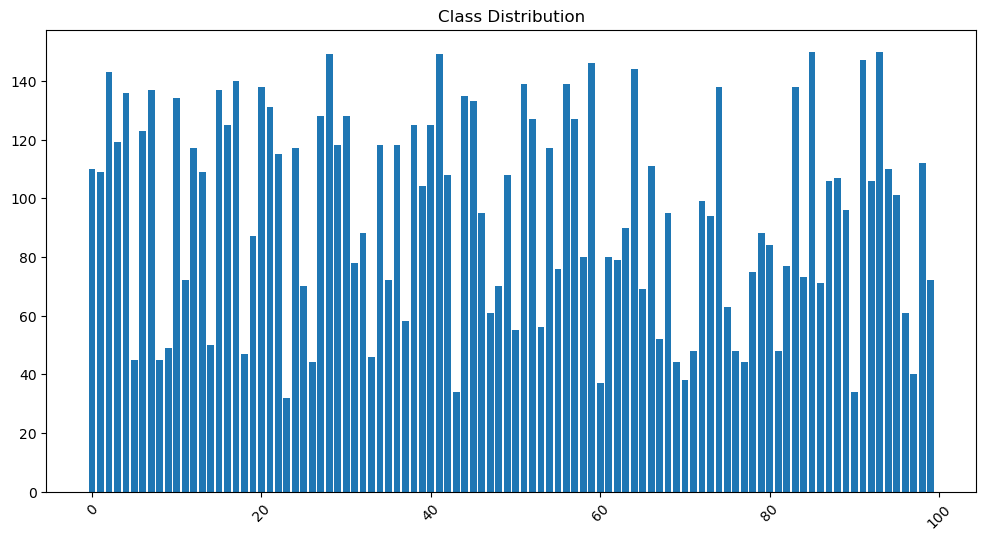

In [3]:
class_counts = {}
class_images = {}
for class_id in range(100):
    class_dir = os.path.join('data/train/', str(class_id))
    if os.path.isdir(class_dir):
        files = sorted(glob.glob(os.path.join(class_dir, '*')))
        class_counts[class_id] = len(files)
        class_images[class_id] = files
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.show()

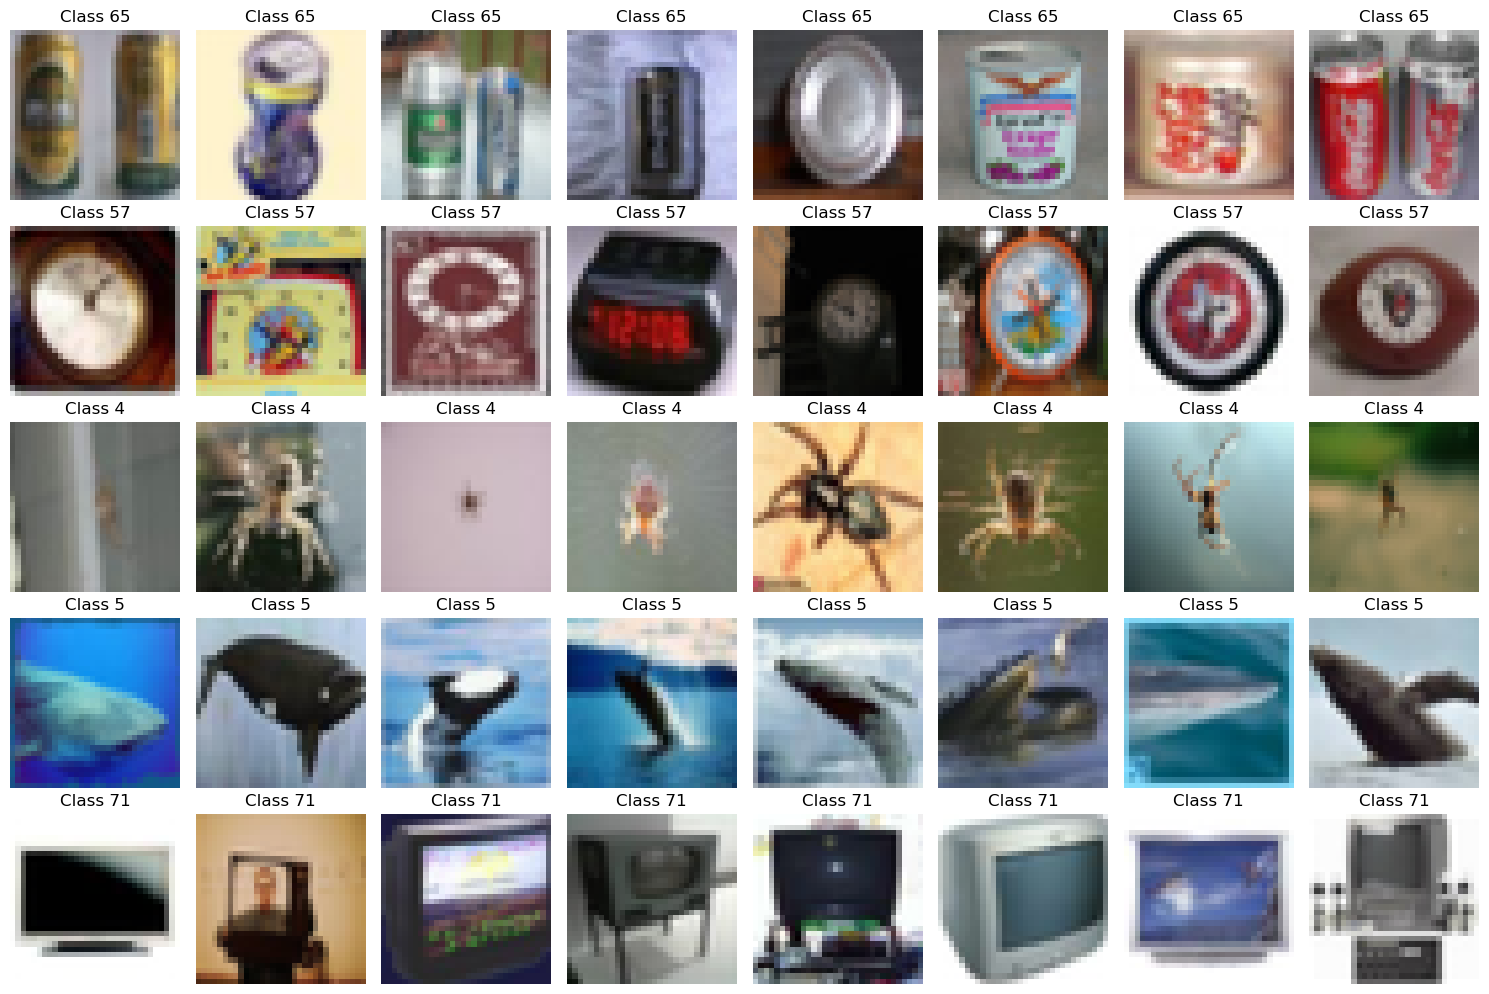

In [4]:
selected_classes = random.sample(range(100), 5)
plt.figure(figsize=(15, 10))

for i, class_id in enumerate(selected_classes):
    images = random.sample(class_images[class_id], 8)
    for j, img_path in enumerate(images):
        plt.subplot(len(selected_classes), 8, i * 8 + j + 1)
        img = plt.imread(img_path)
        plt.imshow(img)
        plt.title(f'Class {class_id}')
        plt.axis('off')

plt.tight_layout()
plt.show()

Тестовые фотографии

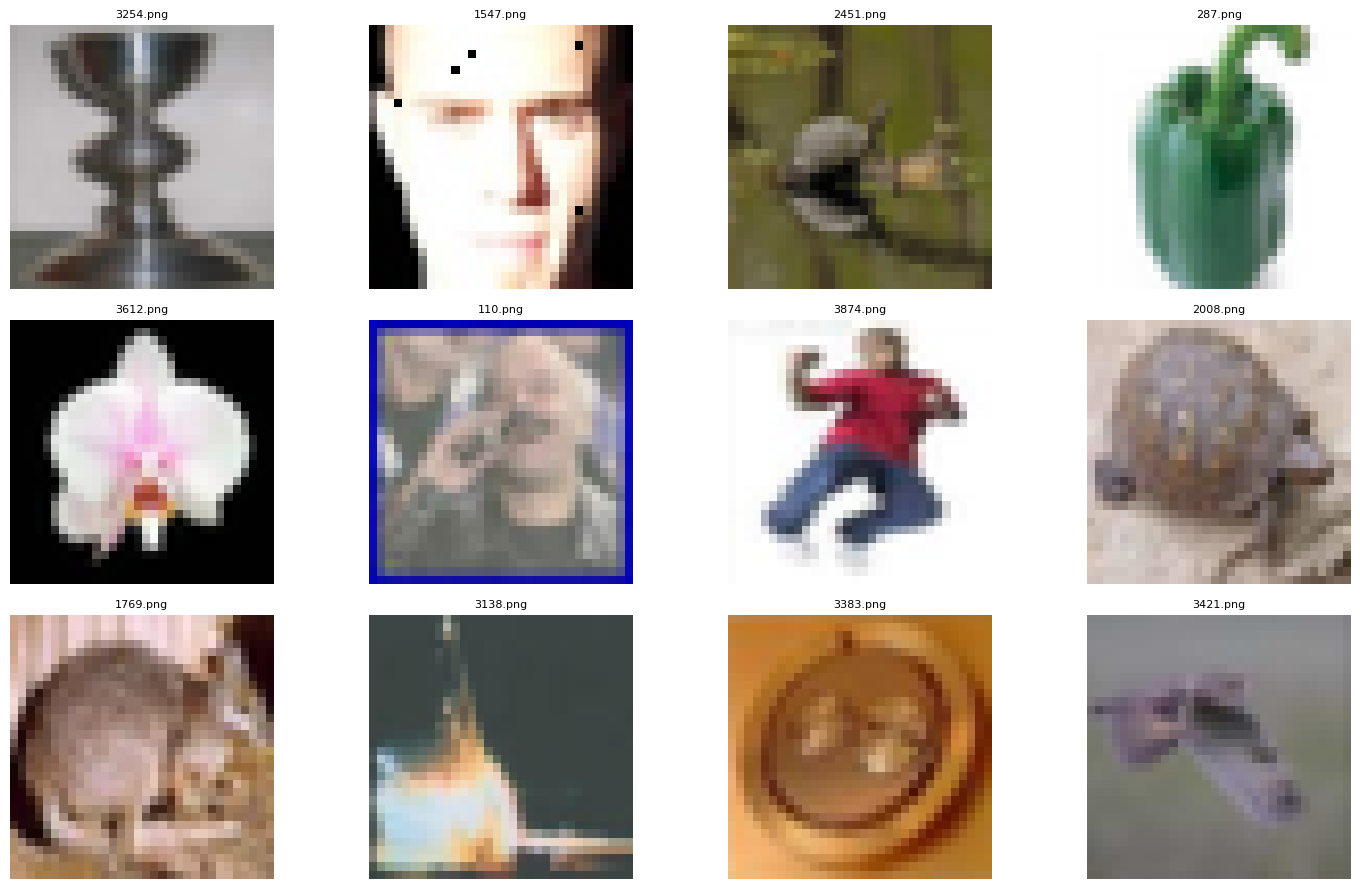

In [6]:
test_images = sorted(glob.glob(os.path.join('data/test/', '*')))
selected_images = random.sample(test_images, 12)
cols = 4  
rows = (12 + cols - 1) // cols  
plt.figure(figsize=(15, 3 * rows))
    
for i, img_path in enumerate(selected_images, 1):
    plt.subplot(rows, cols, i)
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(os.path.basename(img_path), fontsize=8)  
    
plt.tight_layout()
plt.show()

В данных есть сильный дисбаланс классов, поэтому надо сделать в train и val одинаковое соотношение классов. Сами изображения выглядят нормально, без шума, максимум бывают изображения с несколькими выбитыми пикселями. На тестовых фотографиях также не видно каких-то проблем кроме некоторых фотографий с выбитыми пикселями.

# Пункт 2

In [9]:
class Dataset(Dataset):
    def __init__(self, split='train', transform=None, root_dir="data/"): #random_seed = 66
        self.transform = transform
        self.samples = []
        
        if split in ['train', 'val']:
            for class_id in range(100):
                class_dir = os.path.join(root_dir, 'train', str(class_id))
                files = sorted(glob.glob(os.path.join(class_dir, '*')))
                train_files, val_files = train_test_split(files, test_size=0.2) #random_state=random_seed
                
                if split == 'train':
                    selected_files = train_files
                else:
                    selected_files = val_files
                
                for file in selected_files:
                    self.samples.append((file, class_id))
                    
        else:
            test_dir = os.path.join(root_dir, 'test')
            files = sorted(glob.glob(os.path.join(test_dir, '*')))
            for file in files:
                self.samples.append((file, -1))
            
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = cv2.imread(img_path)
        
        if image is None:
            print(f"Не удалось загрузить изображение: {img_path}")
            new_idx = (idx + 1) % len(self.samples)
            return self.__getitem__(new_idx)
            
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
            
        return image, label

# Пункт 3

In [11]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# Модель без навороченных аугментаций и без transfer learning

In [13]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=100):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.Flatten()
        )
        self.classifier = nn.Sequential(
            nn.Linear(64*16*16, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = x.float()  
        x = self.features(x)
        x = self.classifier(x)
        return x

In [14]:
train_simple_transform = A.Compose([
    A.Resize(64, 64),
    A.HorizontalFlip(p=0.5),  
    A.VerticalFlip(p=0.5),  
    ToTensorV2()
])
val_transform = A.Compose([
    A.Resize(64, 64),
    ToTensorV2()
])
train_simple_dataset = Dataset(split='train', transform=train_simple_transform)
val_dataset = Dataset(split='val', transform=val_transform)
train_simple_loader = DataLoader(train_simple_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

warmup_epochs = 5
warmup_scheduler = LinearLR(optimizer, start_factor=0.1, total_iters=warmup_epochs)
main_scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

early_stopping = EarlyStopping(patience=5)
best_val_loss = float('inf')
history = defaultdict(list)

Epoch 1
Train Loss: 4.2300 | Val Loss: 3.6754
Train Acc: 0.0757 | Val Acc: 0.1780
LR: 0.000280

Epoch 2
Train Loss: 4.0041 | Val Loss: 3.3920
Train Acc: 0.1128 | Val Acc: 0.2301
LR: 0.000460

Epoch 3
Train Loss: 3.8124 | Val Loss: 3.2849
Train Acc: 0.1447 | Val Acc: 0.2198
LR: 0.000640

Epoch 4
Train Loss: 3.7027 | Val Loss: 3.2897
Train Acc: 0.1602 | Val Acc: 0.2296
LR: 0.000820

Epoch 5
Train Loss: 3.6376 | Val Loss: 3.2767
Train Acc: 0.1646 | Val Acc: 0.2208
LR: 0.001000

Epoch 6
Train Loss: 3.5741 | Val Loss: 3.1973
Train Acc: 0.1833 | Val Acc: 0.2343
LR: 0.001000

Epoch 7
Train Loss: 3.4785 | Val Loss: 3.1014
Train Acc: 0.1856 | Val Acc: 0.2425
LR: 0.001000

Epoch 8
Train Loss: 3.2950 | Val Loss: 2.9928
Train Acc: 0.2209 | Val Acc: 0.2843
LR: 0.001000

Epoch 9
Train Loss: 3.1216 | Val Loss: 2.8346
Train Acc: 0.2475 | Val Acc: 0.3369
LR: 0.001000

Epoch 10
Train Loss: 2.9793 | Val Loss: 2.6525
Train Acc: 0.2738 | Val Acc: 0.3509
LR: 0.001000

Epoch 11
Train Loss: 2.8708 | Val Loss:

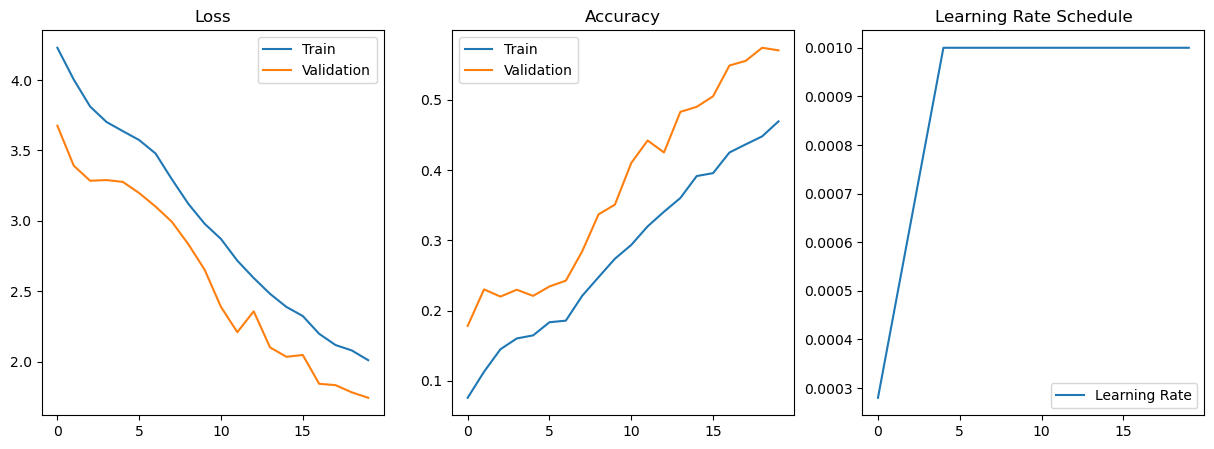

In [16]:
for epoch in range(20):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for inputs, labels in train_simple_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    
    train_loss = train_loss / total
    train_acc = correct / total
    val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    
    if epoch < warmup_epochs:
        warmup_scheduler.step()
    else:
        main_scheduler.step(val_loss) 
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(optimizer.param_groups[0]['lr'])
    
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
    
    print(f"Epoch {epoch+1}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    print(f"LR: {history['lr'][-1]:.6f}\n")

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()

plt.subplot(132)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(133)
plt.plot(history['lr'], label='Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()
plt.show()

Если учить 100 эпох то модель может выдать чуть больше 0.7 accuracy на val, однако это долго и результат далёк от идеала

# Модель без навороченных аугментаций и с transfer learning.

Беру модель resnet18 с 3 и 4 разморженными слоями. 

In [20]:
class TransferModel(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()
        self.backbone = models.resnet18(pretrained=True)
        
        for param in self.backbone.parameters():
            param.requires_grad = False
            
        for param in self.backbone.layer3.parameters():
            param.requires_grad = True
        for param in self.backbone.layer4.parameters():
            param.requires_grad = True
        
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()  
        
        self.head = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        return self.head(x)

In [21]:
train_simple_transfer= A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_simple_transfer = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

train_transfer_dataset = Dataset(split='train', transform=train_simple_transfer)
val_transfer_dataset = Dataset(split='val', transform=val_simple_transfer)

train_transfer_loader = DataLoader(train_transfer_dataset, batch_size=32, shuffle=True)
val_transfer_loader = DataLoader(val_transfer_dataset, batch_size=32, shuffle=False)

In [22]:
model = TransferModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam([
    {'params': model.backbone.layer3.parameters(), 'lr': 1e-4},
    {'params': model.backbone.layer4.parameters(), 'lr': 1e-4},
    {'params': model.head.parameters(), 'lr': 1e-3}
])

warmup_epochs = 5
warmup_scheduler = LinearLR(optimizer, start_factor=0.1, total_iters=warmup_epochs)
main_scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)
early_stopping = EarlyStopping(patience=5)
history = defaultdict(list)
best_val_loss = float('inf')

C:\Users\Petr\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Petr\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1
Train Loss: 4.1485 | Val Loss: 3.4817
Train Acc: 0.1125 | Val Acc: 0.3008
LR: 0.000028

Epoch 2
Train Loss: 2.9088 | Val Loss: 2.0142
Train Acc: 0.3534 | Val Acc: 0.5490
LR: 0.000046

Epoch 3
Train Loss: 1.9710 | Val Loss: 1.3002
Train Acc: 0.5116 | Val Acc: 0.6723
LR: 0.000064

Epoch 4
Train Loss: 1.4868 | Val Loss: 0.9631
Train Acc: 0.5920 | Val Acc: 0.7425
LR: 0.000082

Epoch 5
Train Loss: 1.2100 | Val Loss: 0.8098
Train Acc: 0.6659 | Val Acc: 0.7853
LR: 0.000100

Epoch 6
Train Loss: 1.0280 | Val Loss: 0.7505
Train Acc: 0.7064 | Val Acc: 0.8013
LR: 0.000100

Epoch 7
Train Loss: 0.8124 | Val Loss: 0.6192
Train Acc: 0.7614 | Val Acc: 0.8380
LR: 0.000100

Epoch 8
Train Loss: 0.6569 | Val Loss: 0.5416
Train Acc: 0.8092 | Val Acc: 0.8498
LR: 0.000100

Epoch 9
Train Loss: 0.5550 | Val Loss: 0.5092
Train Acc: 0.8384 | Val Acc: 0.8638
LR: 0.000100

Epoch 10
Train Loss: 0.4407 | Val Loss: 0.4727
Train Acc: 0.8698 | Val Acc: 0.8798
LR: 0.000100

Epoch 11
Train Loss: 0.3703 | Val Loss:

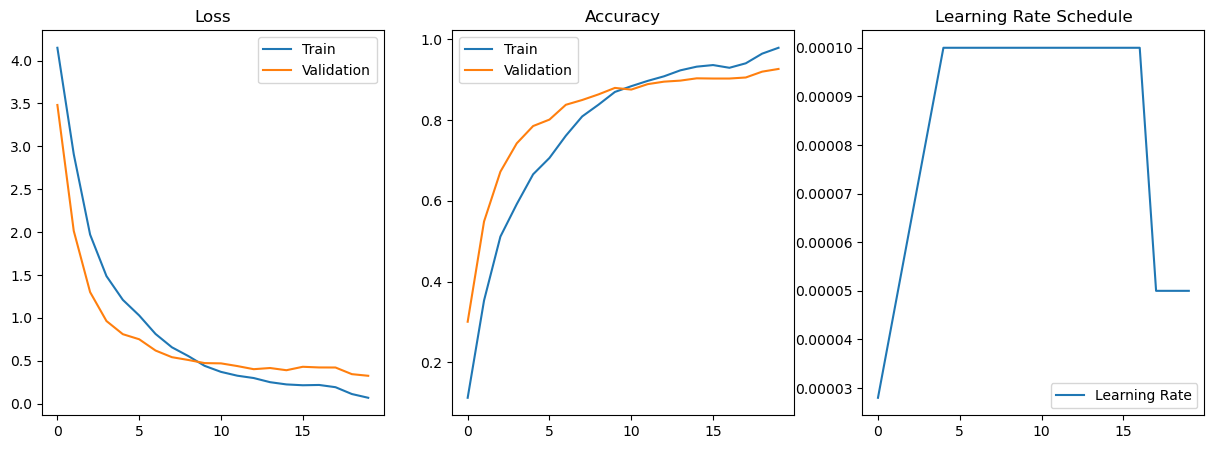

In [23]:
for epoch in range(20):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for inputs, labels in train_transfer_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_transfer_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    
    train_loss = train_loss / total
    train_acc = correct / total
    val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    
    if epoch < warmup_epochs:
        warmup_scheduler.step()
    else:
        main_scheduler.step(val_loss) 
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(optimizer.param_groups[0]['lr'])
    
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
    
    print(f"Epoch {epoch+1}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    print(f"LR: {history['lr'][-1]:.6f}\n")

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()

plt.subplot(132)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(133)
plt.plot(history['lr'], label='Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()
plt.show()

Модель показывает хорошие результаты на val однако на тесте выдаёт примерно 0.56

# Модель с навороченных аугментациями и без transfer learning. 

Предположительно результаты на val и test выборках должны быть ниже чем в предыдущих  моделях, т.к. ни в train/val ни в test выборках не наблюдается каких-то проблем с картинками

In [27]:
train_transform = A.Compose([
    A.Resize(64, 64),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussianBlur(blur_limit=(3, 7)),  
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(64, 64),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])
train_dataset = Dataset(split='train', transform=train_transform)
val_dataset = Dataset(split='val', transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

C:\Users\Petr\anaconda3\Lib\site-packages\albumentations\core\validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [28]:
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

warmup_epochs = 5
warmup_scheduler = LinearLR(optimizer, start_factor=0.1, total_iters=warmup_epochs)
main_scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

early_stopping = EarlyStopping(patience=5)
best_val_loss = float('inf')
history = defaultdict(list)

Epoch 1
Train Loss: 4.3707 | Val Loss: 3.8416
Train Acc: 0.0541 | Val Acc: 0.1434
LR: 0.000280

Epoch 2
Train Loss: 4.1891 | Val Loss: 3.6540
Train Acc: 0.0825 | Val Acc: 0.1584
LR: 0.000460

Epoch 3
Train Loss: 4.1298 | Val Loss: 3.6030
Train Acc: 0.0866 | Val Acc: 0.1744
LR: 0.000640

Epoch 4
Train Loss: 4.0856 | Val Loss: 3.5662
Train Acc: 0.0917 | Val Acc: 0.1739
LR: 0.000820

Epoch 5
Train Loss: 4.0503 | Val Loss: 3.5694
Train Acc: 0.0914 | Val Acc: 0.1703
LR: 0.001000

Epoch 6
Train Loss: 4.0625 | Val Loss: 3.6454
Train Acc: 0.0926 | Val Acc: 0.1481
LR: 0.001000

Epoch 7
Train Loss: 3.9972 | Val Loss: 3.4949
Train Acc: 0.0959 | Val Acc: 0.1816
LR: 0.001000

Epoch 8
Train Loss: 3.9301 | Val Loss: 3.4475
Train Acc: 0.1026 | Val Acc: 0.1863
LR: 0.001000

Epoch 9
Train Loss: 3.8594 | Val Loss: 3.3381
Train Acc: 0.1121 | Val Acc: 0.2038
LR: 0.001000

Epoch 10
Train Loss: 3.7575 | Val Loss: 3.2621
Train Acc: 0.1282 | Val Acc: 0.2121
LR: 0.001000

Epoch 11
Train Loss: 3.6832 | Val Loss:

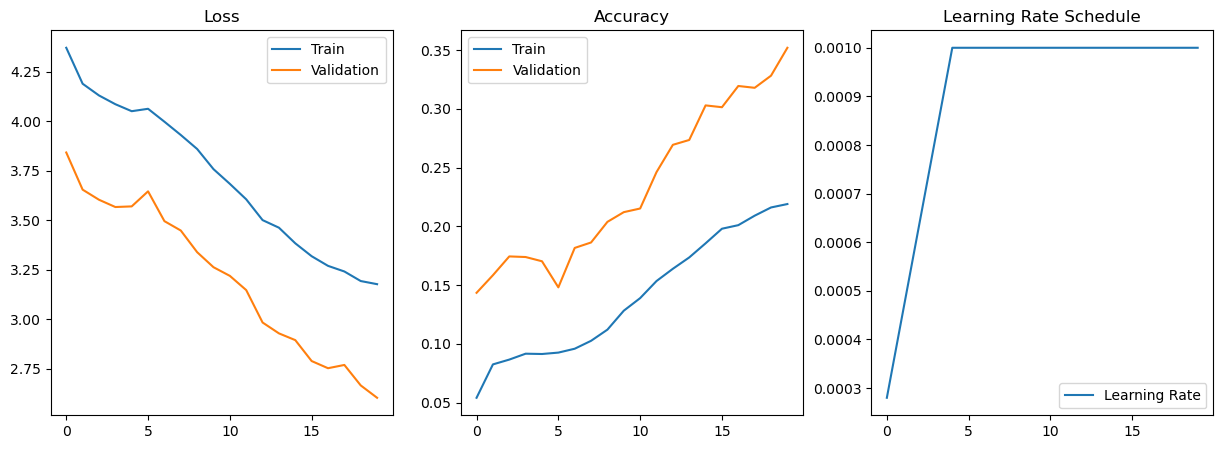

In [29]:
for epoch in range(20):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    
    train_loss = train_loss / total
    train_acc = correct / total
    val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    
    if epoch < warmup_epochs:
        warmup_scheduler.step()
    else:
        main_scheduler.step(val_loss) 
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(optimizer.param_groups[0]['lr'])
    
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
    
    print(f"Epoch {epoch+1}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    print(f"LR: {history['lr'][-1]:.6f}\n")

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()

plt.subplot(132)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(133)
plt.plot(history['lr'], label='Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()
plt.show()

Как и без сложных аугментаций простая модель показывает не лучшие результаты

# Модель с навороченных аугментациями и с transfer learning

In [32]:
train_transfer_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussianBlur(blur_limit=(3, 7)),  
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transfer_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

train_transfer_dataset = Dataset(split='train', transform=train_transfer_transform)  
val_transfer_dataset = Dataset(split='val', transform=val_transfer_transform)

train_transfer_loader = DataLoader(train_transfer_dataset, batch_size=32, shuffle=True)
val_transfer_loader = DataLoader(val_transfer_dataset, batch_size=32, shuffle=False)

In [33]:
model = TransferModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam([
    {'params': model.backbone.layer3.parameters(), 'lr': 1e-4},
    {'params': model.backbone.layer4.parameters(), 'lr': 1e-4},
    {'params': model.head.parameters(), 'lr': 1e-3}
])

warmup_epochs = 5
warmup_scheduler = LinearLR(optimizer, start_factor=0.1, total_iters=warmup_epochs)
main_scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)
early_stopping = EarlyStopping(patience=5)
history = defaultdict(list)
best_val_loss = float('inf')

Epoch 1
Train Loss: 4.2283 | Val Loss: 3.4822
Train Acc: 0.0965 | Val Acc: 0.3230
LR: 0.000028

Epoch 2
Train Loss: 3.0437 | Val Loss: 2.0066
Train Acc: 0.3253 | Val Acc: 0.5299
LR: 0.000046

Epoch 3
Train Loss: 2.1256 | Val Loss: 1.3275
Train Acc: 0.4716 | Val Acc: 0.6615
LR: 0.000064

Epoch 4
Train Loss: 1.6980 | Val Loss: 1.0536
Train Acc: 0.5429 | Val Acc: 0.7038
LR: 0.000082

Epoch 5
Train Loss: 1.4773 | Val Loss: 0.9101
Train Acc: 0.5873 | Val Acc: 0.7353
LR: 0.000100

Epoch 6
Train Loss: 1.3418 | Val Loss: 0.8554
Train Acc: 0.6200 | Val Acc: 0.7456
LR: 0.000100

Epoch 7
Train Loss: 1.1989 | Val Loss: 0.7239
Train Acc: 0.6531 | Val Acc: 0.7822
LR: 0.000100

Epoch 8
Train Loss: 1.0316 | Val Loss: 0.6952
Train Acc: 0.6989 | Val Acc: 0.7962
LR: 0.000100

Epoch 9
Train Loss: 0.9136 | Val Loss: 0.5988
Train Acc: 0.7305 | Val Acc: 0.8277
LR: 0.000100

Epoch 10
Train Loss: 0.8318 | Val Loss: 0.5676
Train Acc: 0.7438 | Val Acc: 0.8344
LR: 0.000100

Epoch 11
Train Loss: 0.7485 | Val Loss:

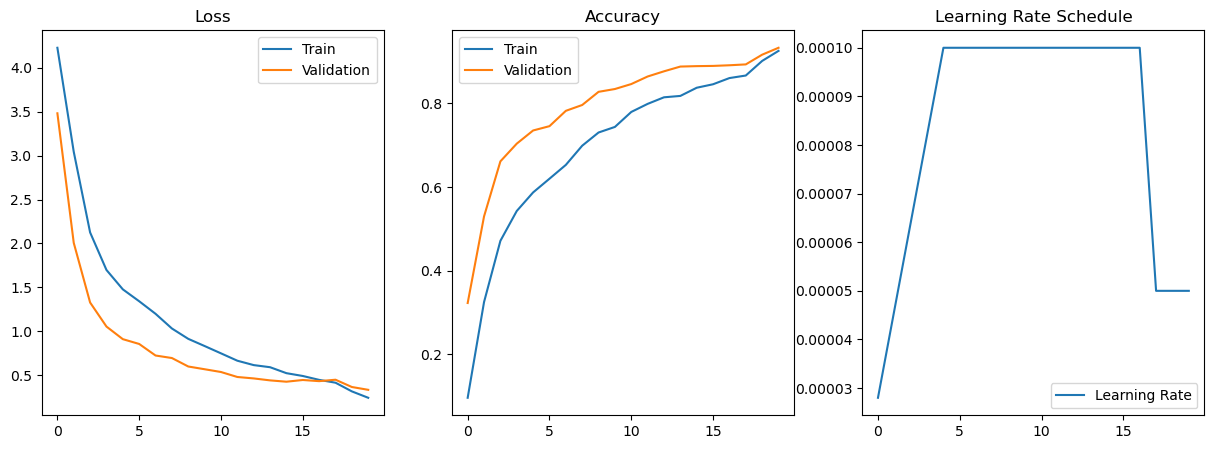

In [34]:
for epoch in range(20):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for inputs, labels in train_transfer_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_transfer_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    
    train_loss = train_loss / total
    train_acc = correct / total
    val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    
    if epoch < warmup_epochs:
        warmup_scheduler.step()
    else:
        main_scheduler.step(val_loss) 
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(optimizer.param_groups[0]['lr'])
    
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
    
    print(f"Epoch {epoch+1}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    print(f"LR: {history['lr'][-1]:.6f}\n")

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()

plt.subplot(132)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(133)
plt.plot(history['lr'], label='Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()
plt.show()

модель выдаёт хороший результат на val однако на кагле результат почти не отличается от модели без навороченных аугментаций и с transfer learning

# Финальная модель (Пункт 4)

в блоке есть всё нужное для запуска финальной модели 

In [38]:
import os
import glob
import cv2
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import defaultdict
import random
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LinearLR, ReduceLROnPlateau
import torchvision.models as models
import torch.nn.functional as F
import pandas as pd

Для работы и со сгенерированными данными меняю функцию init в классе Dataset

In [40]:
class Dataset(Dataset):
    def __init__(self, split='train', transform=None, root_dir="data/", use_generated=False): #random_seed = 66
        self.transform = transform
        self.samples = []
        self.use_generated = use_generated
        
        if split in ['train', 'val']:
            for class_id in range(100):
                original_dir = os.path.join(root_dir, 'train', str(class_id))
                original_files = sorted(glob.glob(os.path.join(original_dir, '*')))
                train_files, val_files = train_test_split(original_files, test_size=0.2)
                
                if split == 'train':
                    selected_files = train_files
                    if use_generated == True:
                        generated_dir = os.path.join(root_dir, 'generated', 'train', str(class_id))
                        generated_files = glob.glob(os.path.join(generated_dir, '*'))
                        selected_files += generated_files
                else:
                    selected_files = val_files
                
                self.samples.extend([(f, class_id) for f in selected_files])
                    
        else:
            test_dir = os.path.join(root_dir, 'test')
            files = glob.glob(os.path.join(test_dir, '*'))
            files.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))
            for file in files:
                self.samples.append((file, -1))
            
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = cv2.imread(img_path)
        
        if image is None:
            print(f"Не удалось загрузить изображение: {img_path}")
            new_idx = (idx + 1) % len(self.samples)
            return self.__getitem__(new_idx)
            
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
            
        return image, label

In [41]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

Сначала я пробовал модель с простым трансформером, однако несмотря на высокие значения accuracy  на val (около 0.94) на кагле значение опускалось  до 0.6, я предположил что проблема в недостаточной обобщающей способности модели, поэтому попробовал использовать сложные аугментации, однако на кагле результат поднялся только на несколько десятых процента. 

In [43]:
train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.CoarseDropout(max_holes=8, max_height=16, max_width=16, fill_value=0, p=0.3),
    A.GaussianBlur(blur_limit=(3, 7)),  
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transfer_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

train_transfer_dataset = Dataset(split='train', transform=train_transform)  
val_transfer_dataset = Dataset(split='val', transform=val_transfer_transform)

train_transfer_loader = DataLoader(train_transfer_dataset, batch_size=32, shuffle=True)
val_transfer_loader = DataLoader(val_transfer_dataset, batch_size=32, shuffle=False)

C:\Users\Petr\AppData\Local\Temp\ipykernel_2576\927774570.py:7: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=16, max_width=16, fill_value=0, p=0.3),


In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class ConditionalGenerator(nn.Module):
    def __init__(self, num_classes=100, latent_dim=100):
        super().__init__()
        self.label_embed = nn.Embedding(num_classes, latent_dim)
        self.main = nn.Sequential(
            nn.Linear(latent_dim + latent_dim, 256),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 3*224*224),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_embed = self.label_embed(labels)
        combined = torch.cat((noise, label_embed), 1)
        img = self.main(combined)
        return img.view(img.size(0), 3, 224, 224)

class ConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()
        self.main = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3*224*224, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
        )
        self.validity = nn.Linear(256, 1)
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, img):
        x = self.main(img)
        return torch.sigmoid(self.validity(x)), self.classifier(x)

generator = ConditionalGenerator().to(device)
discriminator = ConditionalDiscriminator().to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

criterion_adv = nn.BCELoss()
criterion_cls = nn.CrossEntropyLoss()
criterion_cls = nn.CrossEntropyLoss()

for epoch in range(20):
    for imgs, labels in train_transfer_loader:
        real_imgs = imgs.to(device)
        labels = labels.to(device)
        batch_size = real_imgs.size(0)
        
        noise = torch.randn(batch_size, 100, device=device)
        gen_labels = torch.randint(0, 100, (batch_size,), device=device)
        gen_imgs = generator(noise, gen_labels)
        
        optimizer_D.zero_grad()
        real_validity, real_cls = discriminator(real_imgs)
        fake_validity, fake_cls = discriminator(gen_imgs.detach())
        
        d_loss_adv = criterion_adv(real_validity, torch.ones_like(real_validity)) + \
                    criterion_adv(fake_validity, torch.zeros_like(fake_validity))
        d_loss_cls = criterion_cls(real_cls, labels)
        d_loss = d_loss_adv + d_loss_cls
        d_loss.backward()
        optimizer_D.step()
        
        optimizer_G.zero_grad()
        validity, pred_cls = discriminator(gen_imgs)
        g_loss_adv = criterion_adv(validity, torch.ones_like(validity))
        g_loss_cls = criterion_cls(pred_cls, gen_labels)
        g_loss = g_loss_adv + g_loss_cls
        g_loss.backward()
        optimizer_G.step()

In [45]:
def generate_images(generator, num_per_class=50):
    generator.eval()
    for class_id in range(100):
        noise = torch.randn(num_per_class, 100).to(device)
        labels = torch.full((num_per_class,), class_id, device=device)
        with torch.no_grad():
            gen_imgs = generator(noise, labels).cpu()
        
        save_dir = f"data/generated/train/{class_id}"
        os.makedirs(save_dir, exist_ok=True)
        for i in range(num_per_class):
            img = gen_imgs[i].permute(1, 2, 0).numpy()
            img = (img * 255).astype('uint8')
            cv2.imwrite(f"{save_dir}/gen_{i}.png", img)
generate_images(generator)

In [46]:
train_dataset = Dataset(split='train', transform=train_transform, use_generated=True)
train_transfer_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [47]:
class TransferModel(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()
        self.backbone = models.resnet18(pretrained=True)
        
        for param in self.backbone.parameters():
            param.requires_grad = False
            
        for param in self.backbone.layer3.parameters():
            param.requires_grad = True
        for param in self.backbone.layer4.parameters():
            param.requires_grad = True
        
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()  
        
        self.head = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        ) 

    def forward(self, x):
        x = self.backbone(x)
        return self.head(x)

model = TransferModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam([
    {'params': model.backbone.layer3.parameters(), 'lr': 1e-4},
    {'params': model.backbone.layer4.parameters(), 'lr': 1e-4},
    {'params': model.head.parameters(), 'lr': 1e-3}
])

warmup_epochs = 5
warmup_scheduler = LinearLR(optimizer, start_factor=0.1, total_iters=warmup_epochs)
main_scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)
early_stopping = EarlyStopping(patience=5)
history = defaultdict(list)
best_val_loss = float('inf')

Epoch 1
Train Loss: 4.2027 | Val Loss: 3.4613
Train Acc: 0.1076 | Val Acc: 0.2822
LR: 0.000028

Epoch 2
Train Loss: 2.7134 | Val Loss: 2.0565
Train Acc: 0.4410 | Val Acc: 0.5243
LR: 0.000046

Epoch 3
Train Loss: 1.4950 | Val Loss: 1.3440
Train Acc: 0.6605 | Val Acc: 0.6352
LR: 0.000064

Epoch 4
Train Loss: 1.1225 | Val Loss: 1.0888
Train Acc: 0.7097 | Val Acc: 0.6935
LR: 0.000082

Epoch 5
Train Loss: 0.9865 | Val Loss: 0.9750
Train Acc: 0.7341 | Val Acc: 0.7152
LR: 0.000100

Epoch 6
Train Loss: 0.9073 | Val Loss: 0.9506
Train Acc: 0.7490 | Val Acc: 0.7193
LR: 0.000100

Epoch 7
Train Loss: 0.7973 | Val Loss: 0.7874
Train Acc: 0.7739 | Val Acc: 0.7668
LR: 0.000100

Epoch 8
Train Loss: 0.7074 | Val Loss: 0.7384
Train Acc: 0.7980 | Val Acc: 0.7838
LR: 0.000100

Epoch 9
Train Loss: 0.6392 | Val Loss: 0.6539
Train Acc: 0.8161 | Val Acc: 0.8065
LR: 0.000100

Epoch 10
Train Loss: 0.5708 | Val Loss: 0.5783
Train Acc: 0.8322 | Val Acc: 0.8338
LR: 0.000100

Epoch 11
Train Loss: 0.5225 | Val Loss:

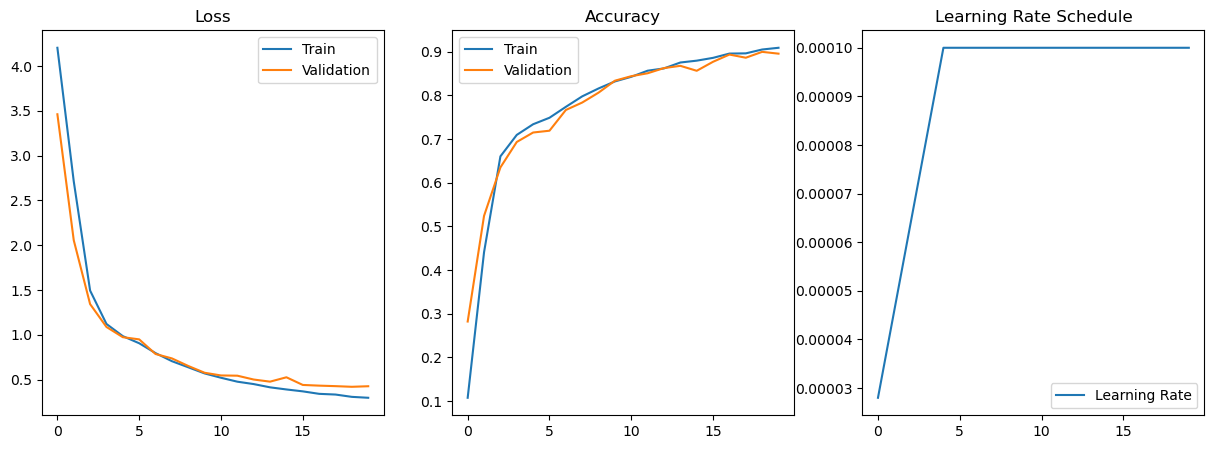

In [48]:
for epoch in range(20):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for inputs, labels in train_transfer_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_transfer_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    
    train_loss = train_loss / total
    train_acc = correct / total
    val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    
    if epoch < warmup_epochs:
        warmup_scheduler.step()
    else:
        main_scheduler.step(val_loss) 
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(optimizer.param_groups[0]['lr'])
    
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
    
    print(f"Epoch {epoch+1}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    print(f"LR: {history['lr'][-1]:.6f}\n")

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()

plt.subplot(132)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(133)
plt.plot(history['lr'], label='Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()
plt.show()

In [49]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval() 
test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

test_dataset = Dataset(split='test', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

predictions = []
file_ids = []

with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)
        predictions.extend(preds.cpu().numpy())

file_ids = [os.path.basename(x[0]).split('.')[0] for x in test_dataset.samples]

results = pd.DataFrame({
    'id': file_ids,
    'target': predictions
})

In [50]:
results

,id,target
0,0,71
1,1,62
2,2,39
3,3,41
4,4,66
...,...,...
3873,3873,74
3874,3874,92
3875,3875,95
3876,3876,91
